# Analyzing the relation between home matches and match wins in the English Premier League (Soccer)

### Vikam Sehgal

### Introduction
Test: https://www.researchgate.net/publication/261402166_Calculating_the_Home_Advantage_in_Soccer_Leagues#:~:text=Home%2Dadvantage%20describes%20the%20benefit,%2C%202014)%20.%20...

Data: https://datahub.io/sports-data/english-premier-league

blah blah blah blahblah blah
With the premier league in full swing, discussion about home field advantage is in full swing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_set_18_19 = pd.read_csv('18_19_data.csv')
data_set_18_19.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


### Loading Data, Transforming, and Tidying
We will now transform, load, and tidy our data so as to be able to run desired operations on it.
Our dataset unfortunately doesn't provide us with an end of season table.
With the given information we can construct our own end of season table. 
We information regarding the matches - what team was the home team, what team was the away team, did the home team win or did the away team win. This is all the questions we need answered to be able to construct our table.

### Steps:
I first create a list of all the teams that are mentioned in the dataset. I iterate over all the matches held in the season and add both the home team and the away team to the "teams" list. Since each team has had multiple matches the list will contain duplicates. We can simply transform the list to a set and then back to a list to be able to store it in our end of season table dataframe.
I then create a dictionary, that stores the team name as the key and a match stat list as their value, with each index corresponding to either a win, loss, draw, home win, home goals scored, home goals conceded.
I then loop over this dictionary and add the stats to our data set.
To add points the english premier league follows a simple princple. For every match won the winning team gets 3 points, every match lost gives the team 0 points, every match that ended as a draw gives both the teams 1 point.

In [3]:
# group by teams to create columns of team, wins, loss, home wins, home goals scored, home goals conceded
def data_to_df(data_set):
    teams = []
    team_stat = {}
    for i in data_set.iterrows():
        teams.append(i[1].HomeTeam)
        teams.append(i[1].AwayTeam)
    #remove duplicates from teams
    teams = set(teams)
    for i in teams:
        team_stat[i] = [0,0,0,0,0,0,0]
    for i in data_set.iterrows():
        team_stat[i[1].HomeTeam][0]+=1
        team_stat[i[1].AwayTeam][0]+=1
        team_stat[i[1].HomeTeam][5]+=i[1].FTHG
        team_stat[i[1].HomeTeam][6]+=i[1].FTAG
        if i[1].FTHG > i[1].FTAG:
            team_stat[i[1].HomeTeam][1]+=1
            team_stat[i[1].HomeTeam][4]+=1
            team_stat[i[1].AwayTeam][2]+=1
        elif i[1].FTHG < i[1].FTAG:
            team_stat[i[1].AwayTeam][1]+=1
            team_stat[i[1].HomeTeam][2]+=1
        else:
            team_stat[i[1].HomeTeam][3]+=1
            team_stat[i[1].AwayTeam][3]+=1
    # print(team_stat)
    mp, wins, loss, draw, hw, hgs, hgc = [],[],[],[],[], [], []
    for v in team_stat:
        mp.append(team_stat[v][0])
        wins.append(team_stat[v][1])
        loss.append(team_stat[v][2])
        draw.append(team_stat[v][3])
        hw.append(team_stat[v][4])
        hgs.append(team_stat[v][5])
        hgc.append(team_stat[v][6])
    points = []
    #calculate points
    for i in range(0,len(mp)):
        points.append(wins[i]*3 + draw[i])
    epl_table = pd.DataFrame(data={'team': list(teams), 'matches_played': mp,
                                   'wins':wins, 'loss':loss,
                                   'draw':draw, 'home_win': hw,
                                  'points': points, 'home_goals': hgs,
                                  'home_goals_conceded': hgc})
    return epl_table
epl_table = data_to_df(data_set_18_19)
epl_points = epl_table.sort_values(by=['points'], ascending=False)
epl_home_games = epl_table.sort_values(by=['home_win'], ascending=False)

In [4]:
# End of season table sorted by points.
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
18,Man City,38,32,4,2,18,98,57,12
0,Liverpool,38,30,1,7,17,97,55,10
5,Chelsea,38,21,8,9,12,72,39,12
1,Tottenham,38,23,13,2,12,71,34,16
19,Arsenal,38,21,10,7,14,70,42,16
13,Man United,38,19,10,9,10,66,33,25
16,Wolves,38,16,13,9,10,57,28,21
14,Everton,38,15,14,9,10,54,30,21
6,Leicester,38,15,16,7,8,52,24,20
12,West Ham,38,15,16,7,9,52,32,27


In [5]:
# End of season table sorted by the number of home games won
epl_home_games

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded
18,Man City,38,32,4,2,18,98,57,12
0,Liverpool,38,30,1,7,17,97,55,10
19,Arsenal,38,21,10,7,14,70,42,16
5,Chelsea,38,21,8,9,12,72,39,12
1,Tottenham,38,23,13,2,12,71,34,16
14,Everton,38,15,14,9,10,54,30,21
16,Wolves,38,16,13,9,10,57,28,21
13,Man United,38,19,10,9,10,66,33,25
12,West Ham,38,15,16,7,9,52,32,27
3,Watford,38,14,16,8,8,50,26,28


### Adding Stats
Now that we have our single season table, we will add some new features
We will calculate the following:
 1. Home Win % = home_win / home matches_played (19)
 2. Total Win % = wins / matches_played

In [6]:
epl_points['home_win%'] = epl_points['home_win']/19
epl_points['total_win%'] = epl_points['wins']/epl_points['matches_played']
epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%
18,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105
0,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474
5,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632
1,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263
19,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632
13,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000
16,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053
14,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737
6,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737
12,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737


To get an idea of what advantage a home game gives we add the 'home_advantage' feature.
Home advantage in the english premier league is calculated as follows:
 Home Advantage = (Home Goals Scored - Home Goals Conceded) / 19

source: https://www.pinnacle.com/en/betting-articles/Soccer/Home-Field-Advantage/FGU2ZXMPGZCTFHSE

In [7]:
epl_points['home_advantage'] = (epl_points['home_goals'] - epl_points['home_goals_conceded']) /19
len(epl_points

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage
18,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105,2.368421
0,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474,2.368421
5,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632,1.421053
1,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263,0.947368
19,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632,1.368421
13,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000,0.421053
16,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053,0.368421
14,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737,0.473684
6,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737,0.210526
12,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737,0.263158


### Plot for season 18-19
We now visualize the home advantage and the home_win% by plotting scatter plots.
Here the x axis is the team, and y axis is the home advantage and home_win%.

These plots give us a rough visual idea of the home advantage and home_win% over the season.

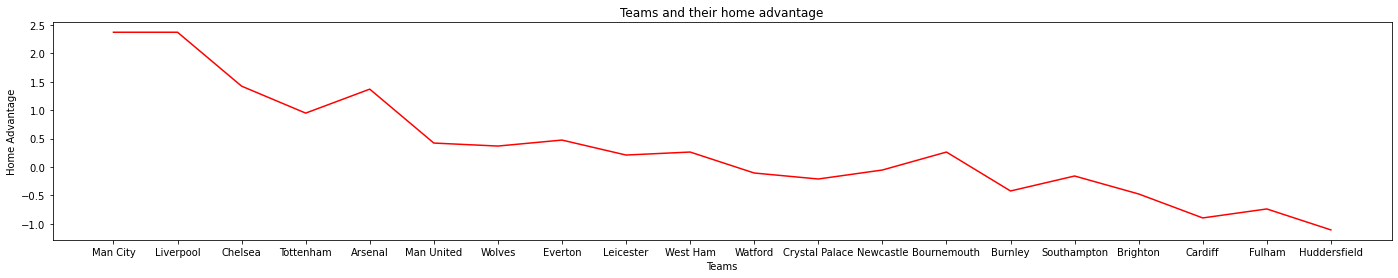

In [8]:
plt.figure(figsize=(24,4))
plt.plot(epl_points['team'], epl_points['home_advantage'], 'r-', label='win_adv')
plt.title('Teams and their home advantage')
plt.xlabel('Teams')
plt.ylabel('Home Advantage')
plt.show()

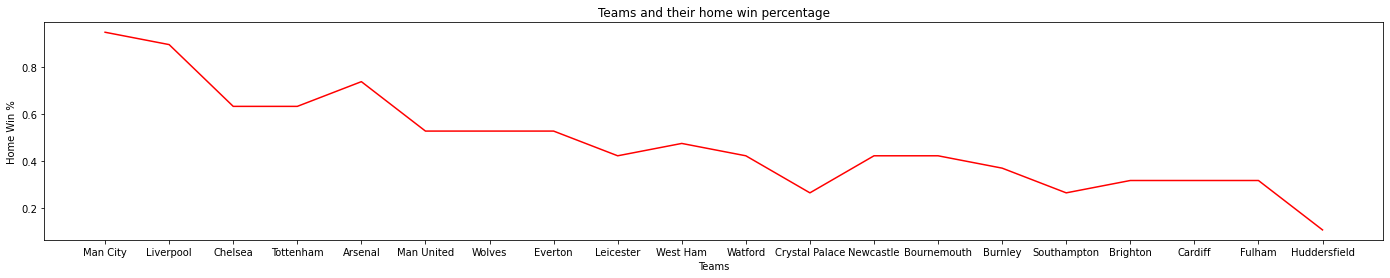

In [9]:
plt.figure(figsize=(24,4))
plt.plot(epl_points['team'], epl_points['home_win%'], 'r-', label='win_adv')
plt.title('Teams and their home win percentage')
plt.xlabel('Teams')
plt.ylabel('Home Win %')
plt.show()

### Observation:
some observation here.....

Let us look at the data from past 5 seasons to get a better idea

In [25]:
# Load data from other 4 seasons: 14-15, 15-16, 16-17, 17-18
epl_table1415 = data_to_df(pd.read_csv('14_15_data.csv'))
epl_table1516 = data_to_df(pd.read_csv('15_16_data.csv'))
epl_table1617 = data_to_df(pd.read_csv('16_17_data.csv'))
epl_table1718 = data_to_df(pd.read_csv('17_18_data.csv'))
epl_table1819 = epl_points
lst = [epl_table1415, epl_table1516, epl_table1617, epl_table1718]
year = 0
epl_table1819['year'] = [2018]*20
for i in lst:
    i['home_win%'] = epl_points['home_win']/19
    i['total_win%'] = epl_points['wins']/epl_points['matches_played']
    i['home_advantage'] = (i['home_goals'] - i['home_goals_conceded']) /19
    i['year'] = [2014 + year]*20
    year += 1
    
epl_table1819

,team,matches_played,wins,loss,draw,home_win,points,home_goals,home_goals_conceded,home_win%,total_win%,home_advantage,year
18,Man City,38,32,4,2,18,98,57,12,0.947368,0.842105,2.368421,2018
0,Liverpool,38,30,1,7,17,97,55,10,0.894737,0.789474,2.368421,2018
5,Chelsea,38,21,8,9,12,72,39,12,0.631579,0.552632,1.421053,2018
1,Tottenham,38,23,13,2,12,71,34,16,0.631579,0.605263,0.947368,2018
19,Arsenal,38,21,10,7,14,70,42,16,0.736842,0.552632,1.368421,2018
13,Man United,38,19,10,9,10,66,33,25,0.526316,0.500000,0.421053,2018
16,Wolves,38,16,13,9,10,57,28,21,0.526316,0.421053,0.368421,2018
14,Everton,38,15,14,9,10,54,30,21,0.526316,0.394737,0.473684,2018
6,Leicester,38,15,16,7,8,52,24,20,0.421053,0.394737,0.210526,2018
12,West Ham,38,15,16,7,9,52,32,27,0.473684,0.394737,0.263158,2018


### Display Scatter plot for each season by their win advantage

sort each table by points so we get a relation between the teams performance and their home advantage. The x axis even though only says the name is actually sorted based on their performance in the season. 
Left to right, is best to worst.



Left -> Right

Best -> Worst

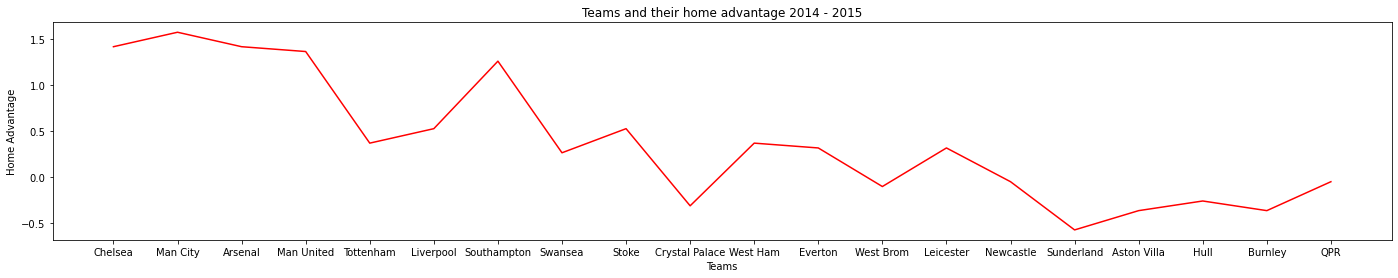

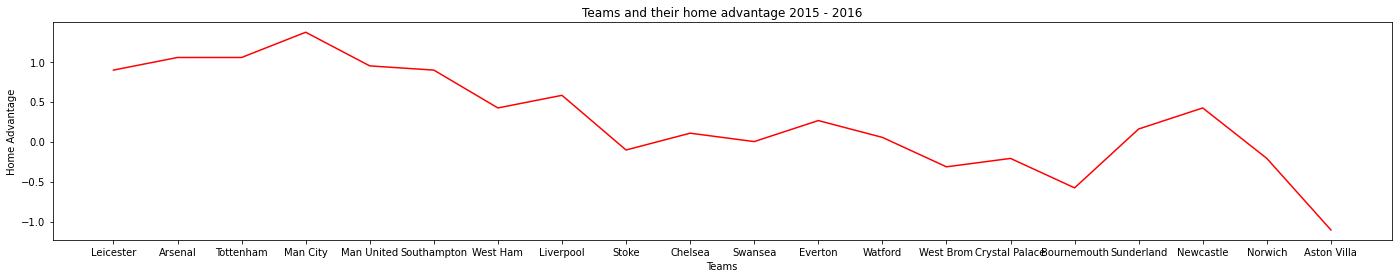

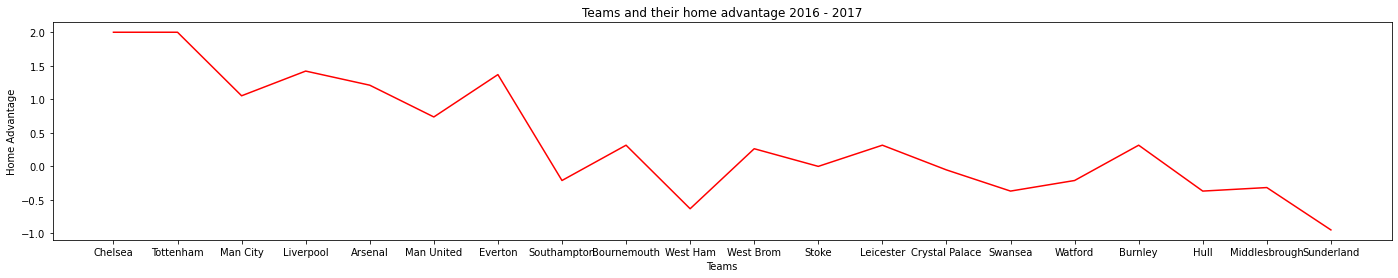

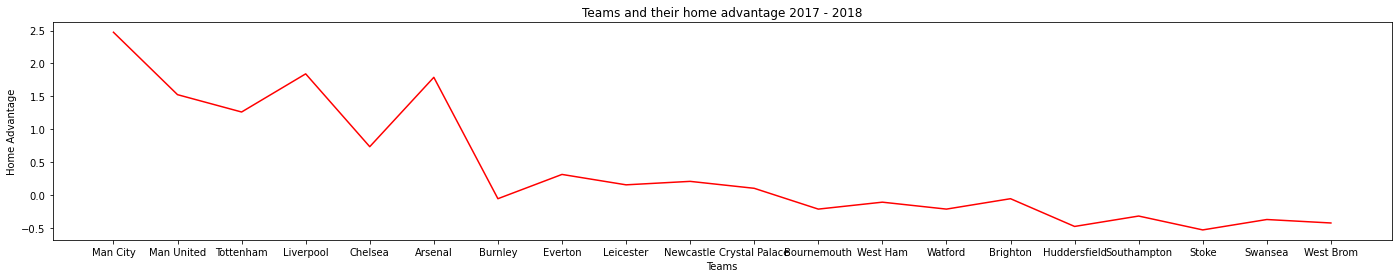

In [20]:
lst = [epl_table1415, epl_table1516, epl_table1617, epl_table1718]
lst2 = ['2014 - 2015','2015 - 2016','2016 - 2017','2017 - 2018']
for ind, val in enumerate(lst):
    val = val.sort_values(by=['points'], ascending=False)
    plt.figure(figsize=(24,4))
    plt.plot(val['team'], val['home_advantage'], 'r-', label='win_adv')
    plt.title('Teams and their home advantage ' + lst2[ind])
    plt.xlabel('Teams')
    plt.ylabel('Home Advantage')
    plt.show()

In [26]:
combined_table = pd.concat([epl_table1415, epl_table1516, epl_table1617, epl_table1718, epl_table1819], axis=0)

<AxesSubplot:xlabel='year', ylabel='home_advantage'>

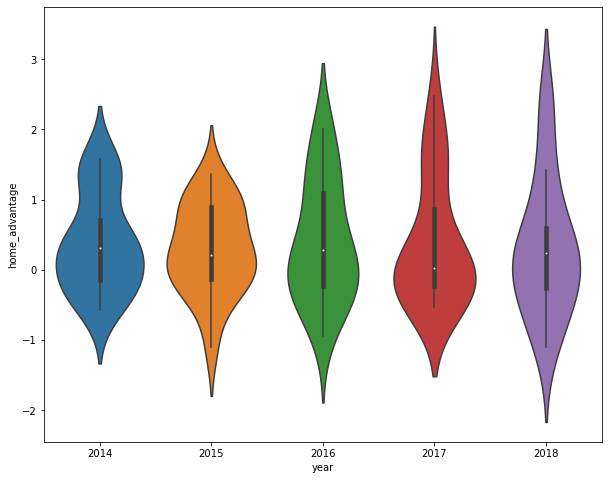

In [29]:
increments = ['2014', '2015', '2016', '2017', '2018']
table_five_years = combined_table.loc[combined_table['year'].isin(increments)]
table_five_years
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.violinplot(ax=ax, x=table_five_years['year'], y=table_five_years['home_advantage'])